<a href="https://colab.research.google.com/github/andyluken/transformers/blob/main/VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#set up the environmentpip
!pip install torch torchvision matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# define the encoder, decoder and VAE
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    h = torch.relu(self.fc1(x))
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(latent_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    h = torch.relu(self.fc1(z))
    x_hat = torch.sigmoid(self.fc2(h))
    return x_hat


# VAE
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

  def forward(self, x):
    mu, logvar = self.encoder(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)

    z = mu + eps * std
    x_hat = self.decoder(z)

    return x_hat, mu, logvar

In [8]:
# Loss function for VAEs. made up of reconstruction loss + KL divergence loss
def loss_function(x, x_hat, mu, logvar):
  BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)- logvar.exp())
  return BCE + KLD

In [12]:
# training VAE using MNIST dataset
#hyperparameters
input_dim = 784 #[28, 28]
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 50

#dataloader
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#model, optimizer
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

# training loop
model.train()
for epoch in range(epochs):
  train_loss = 0
  for x, _ in train_loader:
    x = x.view(-1, input_dim)
    optimizer.zero_grad()
    x_hat, mu, logvar = model(x)
    loss = loss_function(x, x_hat, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")



Epoch 1, Loss: 285.89399348958335
Epoch 2, Loss: 257.3371536458333
Epoch 3, Loss: 251.19724381510417
Epoch 4, Loss: 248.1699609375
Epoch 5, Loss: 246.40737718098958
Epoch 6, Loss: 245.34599700520835
Epoch 7, Loss: 244.44843115234374
Epoch 8, Loss: 243.79074443359374
Epoch 9, Loss: 243.28850859375
Epoch 10, Loss: 242.8516443684896
Epoch 11, Loss: 242.51446712239584
Epoch 12, Loss: 242.19589625651042
Epoch 13, Loss: 241.91254954427083
Epoch 14, Loss: 241.6532969075521
Epoch 15, Loss: 241.45733818359375
Epoch 16, Loss: 241.20958056640626
Epoch 17, Loss: 241.04694886067708
Epoch 18, Loss: 240.84831087239584
Epoch 19, Loss: 240.73523580729167
Epoch 20, Loss: 240.593165625
Epoch 21, Loss: 240.46102278645833
Epoch 22, Loss: 240.37406100260418
Epoch 23, Loss: 240.19611940104167
Epoch 24, Loss: 240.10424664713543
Epoch 25, Loss: 239.9741671549479
Epoch 26, Loss: 239.91360013020832
Epoch 27, Loss: 239.8395576171875
Epoch 28, Loss: 239.7488876627604
Epoch 29, Loss: 239.6769611653646
Epoch 30, Los

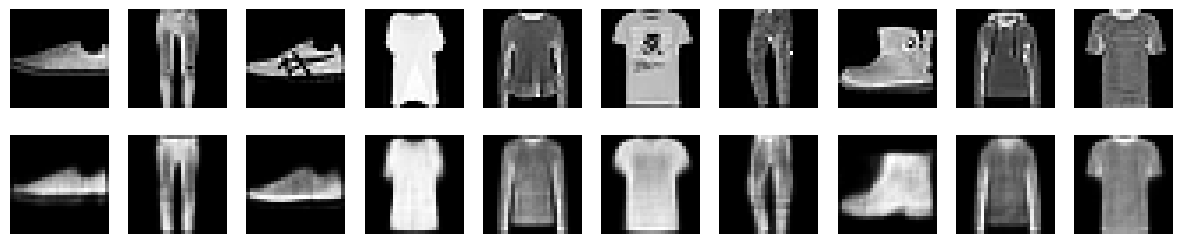

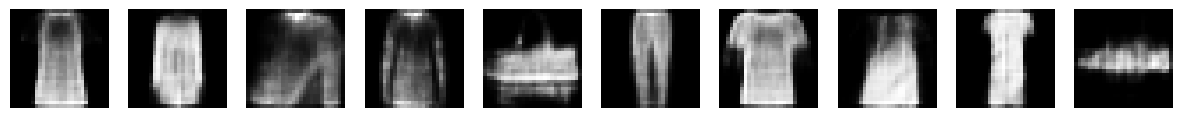

In [13]:
# Testing and evaluating the trained model
# visualizinf reconstruction outputs
model.eval()
with torch.no_grad():
  x, _ = next(iter(train_loader))
  x = x.view(-1, input_dim)
  x_hat, _, _ = model(x)
  x = x.view(-1, 28, 28)
  x_hat = x_hat.view(-1, 28, 28)

  fig, axs = plt.subplots(2, 10, figsize=(15, 3))
  for i in range(10):
    axs[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
    axs[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
  plt.show()

  # visualize the generated samples
  with torch.no_grad():
    z = torch.randn(10, latent_dim)
    sample = model.decoder(z)
    sample = sample.view(-1, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
      axs[i].imshow(sample[i].cpu().numpy(), cmap='gray')
      axs[i].axis('off')
    plt.show()
